In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random 
import os.path
from pathlib import Path


In [2]:
# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
#from tensorflow.keras.layers import preprocessing
from tensorflow.keras.optimizers import Adam

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

In [3]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    #tf.compat.v1.keras.backend.set_session(sess)
    #keras.backend.set_session(sess)

seed_everything()

In [4]:
data = r'C:\Users\rupsy\OneDrive\Desktop\Internship Projects\Projects-20240722T093004Z-001\Projects\animal_classification\Animal Classification\dataset'

In [5]:
data

'C:\\Users\\rupsy\\OneDrive\\Desktop\\Internship Projects\\Projects-20240722T093004Z-001\\Projects\\animal_classification\\Animal Classification\\dataset'

In [6]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [7]:
import urllib.request

url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
output_file = "helper_functions.py"

urllib.request.urlretrieve(url, output_file)
print(f"{output_file} downloaded successfully.")

helper_functions.py downloaded successfully.


In [8]:
#wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [9]:
# Walk through each directory
dataset = r"C:\Users\rupsy\OneDrive\Desktop\Internship Projects\Projects-20240722T093004Z-001\Projects\animal_classification\Animal Classification\dataset"
walk_through_dir(dataset)

There are 15 directories and 0 images in 'C:\Users\rupsy\OneDrive\Desktop\Internship Projects\Projects-20240722T093004Z-001\Projects\animal_classification\Animal Classification\dataset'.
There are 0 directories and 125 images in 'C:\Users\rupsy\OneDrive\Desktop\Internship Projects\Projects-20240722T093004Z-001\Projects\animal_classification\Animal Classification\dataset\Bear'.
There are 0 directories and 137 images in 'C:\Users\rupsy\OneDrive\Desktop\Internship Projects\Projects-20240722T093004Z-001\Projects\animal_classification\Animal Classification\dataset\Bird'.
There are 0 directories and 123 images in 'C:\Users\rupsy\OneDrive\Desktop\Internship Projects\Projects-20240722T093004Z-001\Projects\animal_classification\Animal Classification\dataset\Cat'.
There are 0 directories and 131 images in 'C:\Users\rupsy\OneDrive\Desktop\Internship Projects\Projects-20240722T093004Z-001\Projects\animal_classification\Animal Classification\dataset\Cow'.
There are 0 directories and 127 images in '

In [10]:
dataset

'C:\\Users\\rupsy\\OneDrive\\Desktop\\Internship Projects\\Projects-20240722T093004Z-001\\Projects\\animal_classification\\Animal Classification\\dataset'

In [11]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

C:\Users\rupsy\AppData\Local\Temp\ipykernel_19712\2614691401.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
C:\Users\rupsy\AppData\Local\Temp\ipykernel_19712\2614691401.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(label_counts.index, rotation=45)


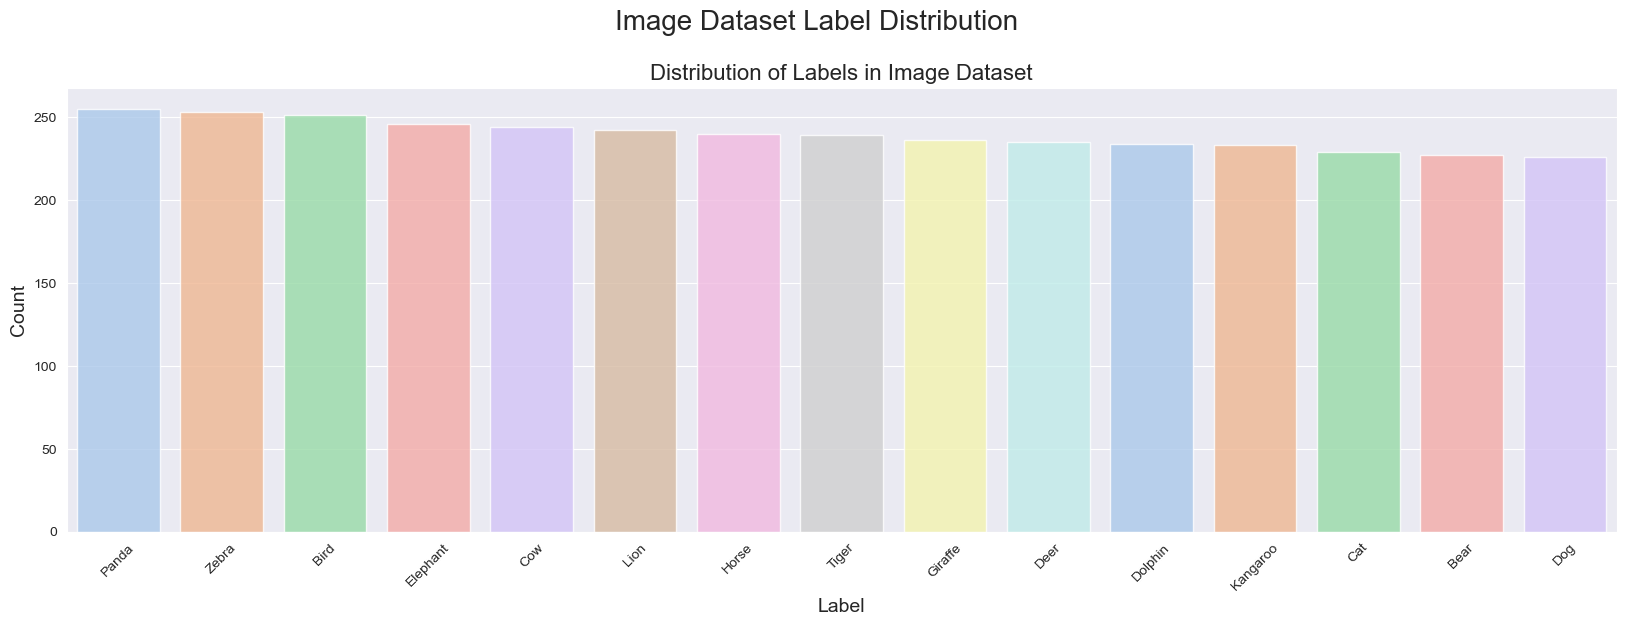

In [12]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

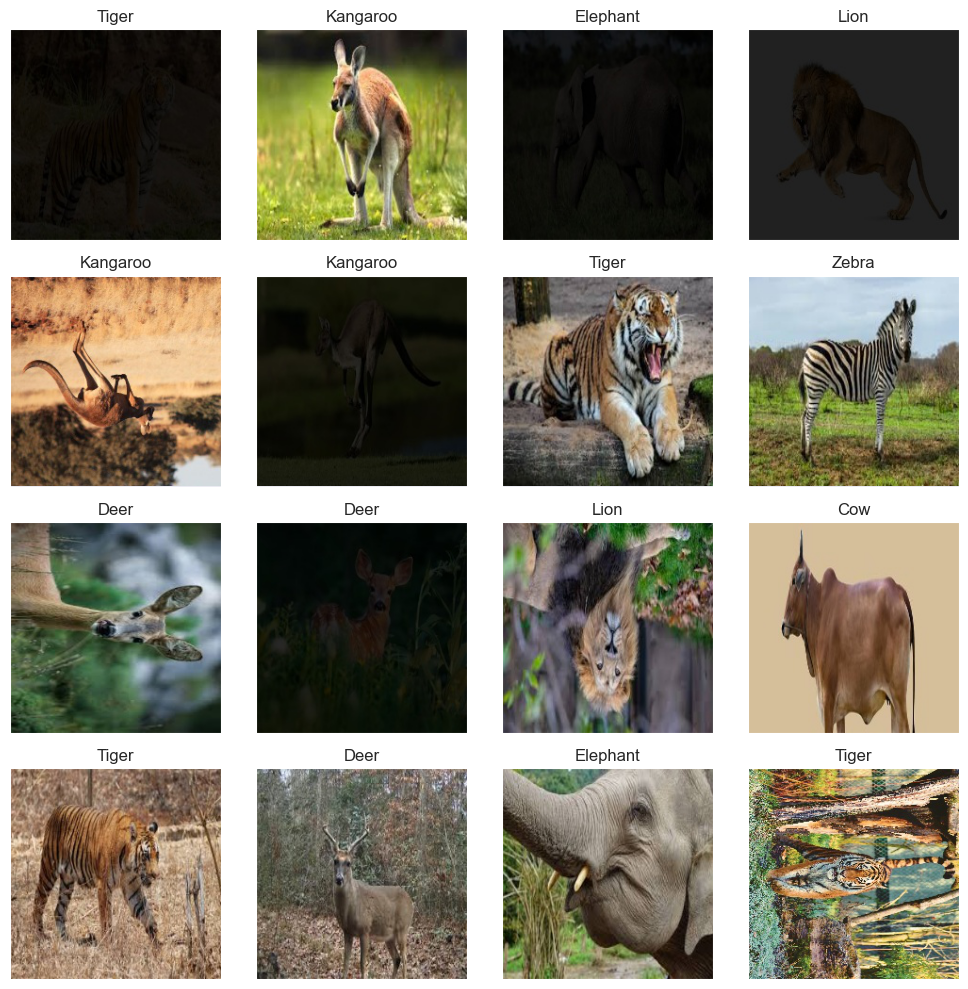

In [13]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [14]:

def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

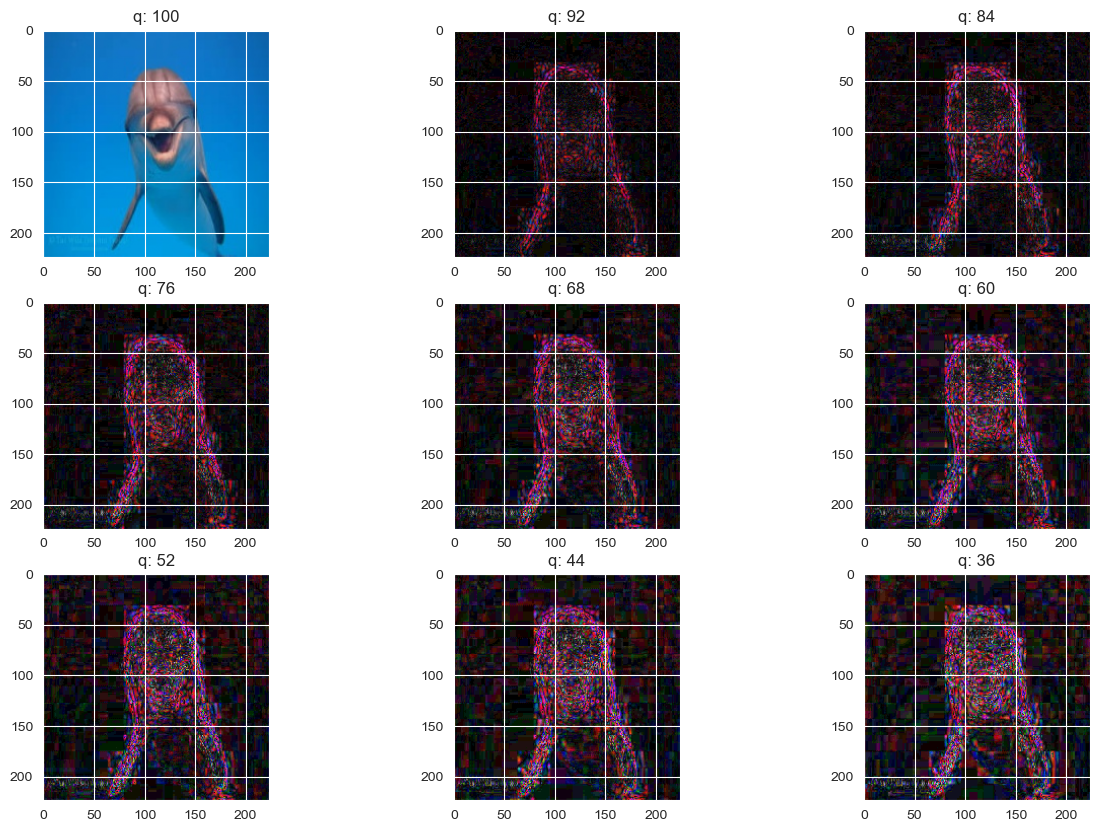

In [16]:
# View random sample from the dataset
p = random_sample(r'C:\Users\rupsy\OneDrive\Desktop\Internship Projects\Projects-20240722T093004Z-001\Projects\animal_classification\Animal Classification\dataset\Dolphin')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [17]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2298 validated image filenames belonging to 15 classes.
Found 574 validated image filenames belonging to 15 classes.
Found 718 validated image filenames belonging to 15 classes.


In [18]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [19]:
# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [21]:
inputs = pretrained_model.input
#x = augment(inputs)
x= inputs
x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(15, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=5,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "animals_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)


Saving TensorBoard log files to: training_logs/animals_classification/20250131-191930
Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 1843s 26s/step - accuracy: 0.0917 - loss: 3.8383 - val_accuracy: 0.1045 - val_loss: 2.7016 - learning_rate: 1.0000e-05
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 782s 11s/step - accuracy: 0.1269 - loss: 3.4008 - val_accuracy: 0.3380 - val_loss: 2.2751 - learning_rate: 1.0000e-05
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 1147s 16s/step - accuracy: 0.1502 - loss: 3.3009 - val_accuracy: 0.4443 - val_loss: 2.0044 - learning_rate: 1.0000e-05
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 1110s 15s/step - accuracy: 0.2062 - loss: 2.8512 - val_accuracy: 0.5052 - val_loss: 1.7881 - learning_rate: 1.0000e-05
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 642s 9s/step - accuracy: 0.2507 - loss: 2.7194 - val_accuracy: 0.5470 - val_loss: 1.6167 - learning_rate: 1.0000e-05


I have taken here only 5 epochs because of time taken to load data as in this dataset I have large data. And because of that my accuracy comes less. If you want increase accuracy you can increase your eppochs to 50 or 100. It will give you 99% of accuracy.

In [24]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 5))

    Test Loss: 1.64365
Test Accuracy: 2.66%


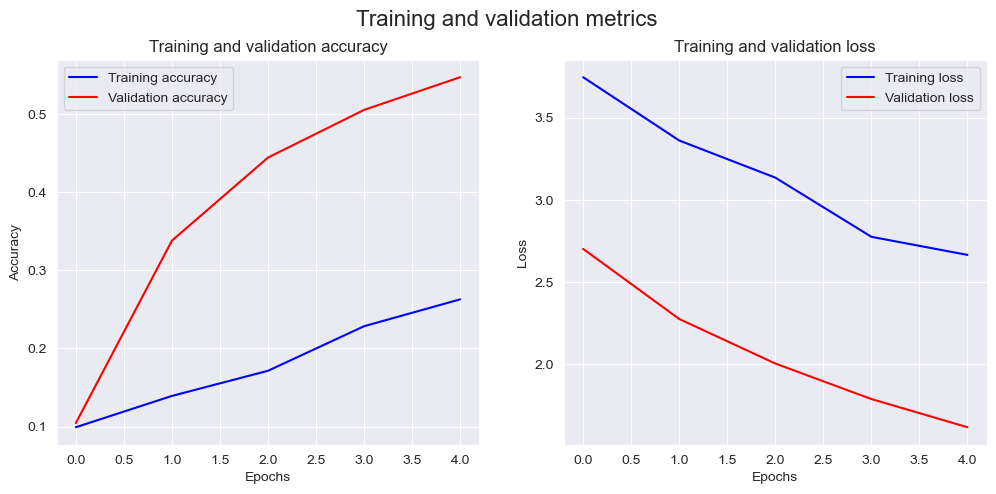

In [25]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

In [26]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 194s 8s/step
The first 5 predictions: ['Panda', 'Cat', 'Kangaroo', 'Panda', 'Deer']


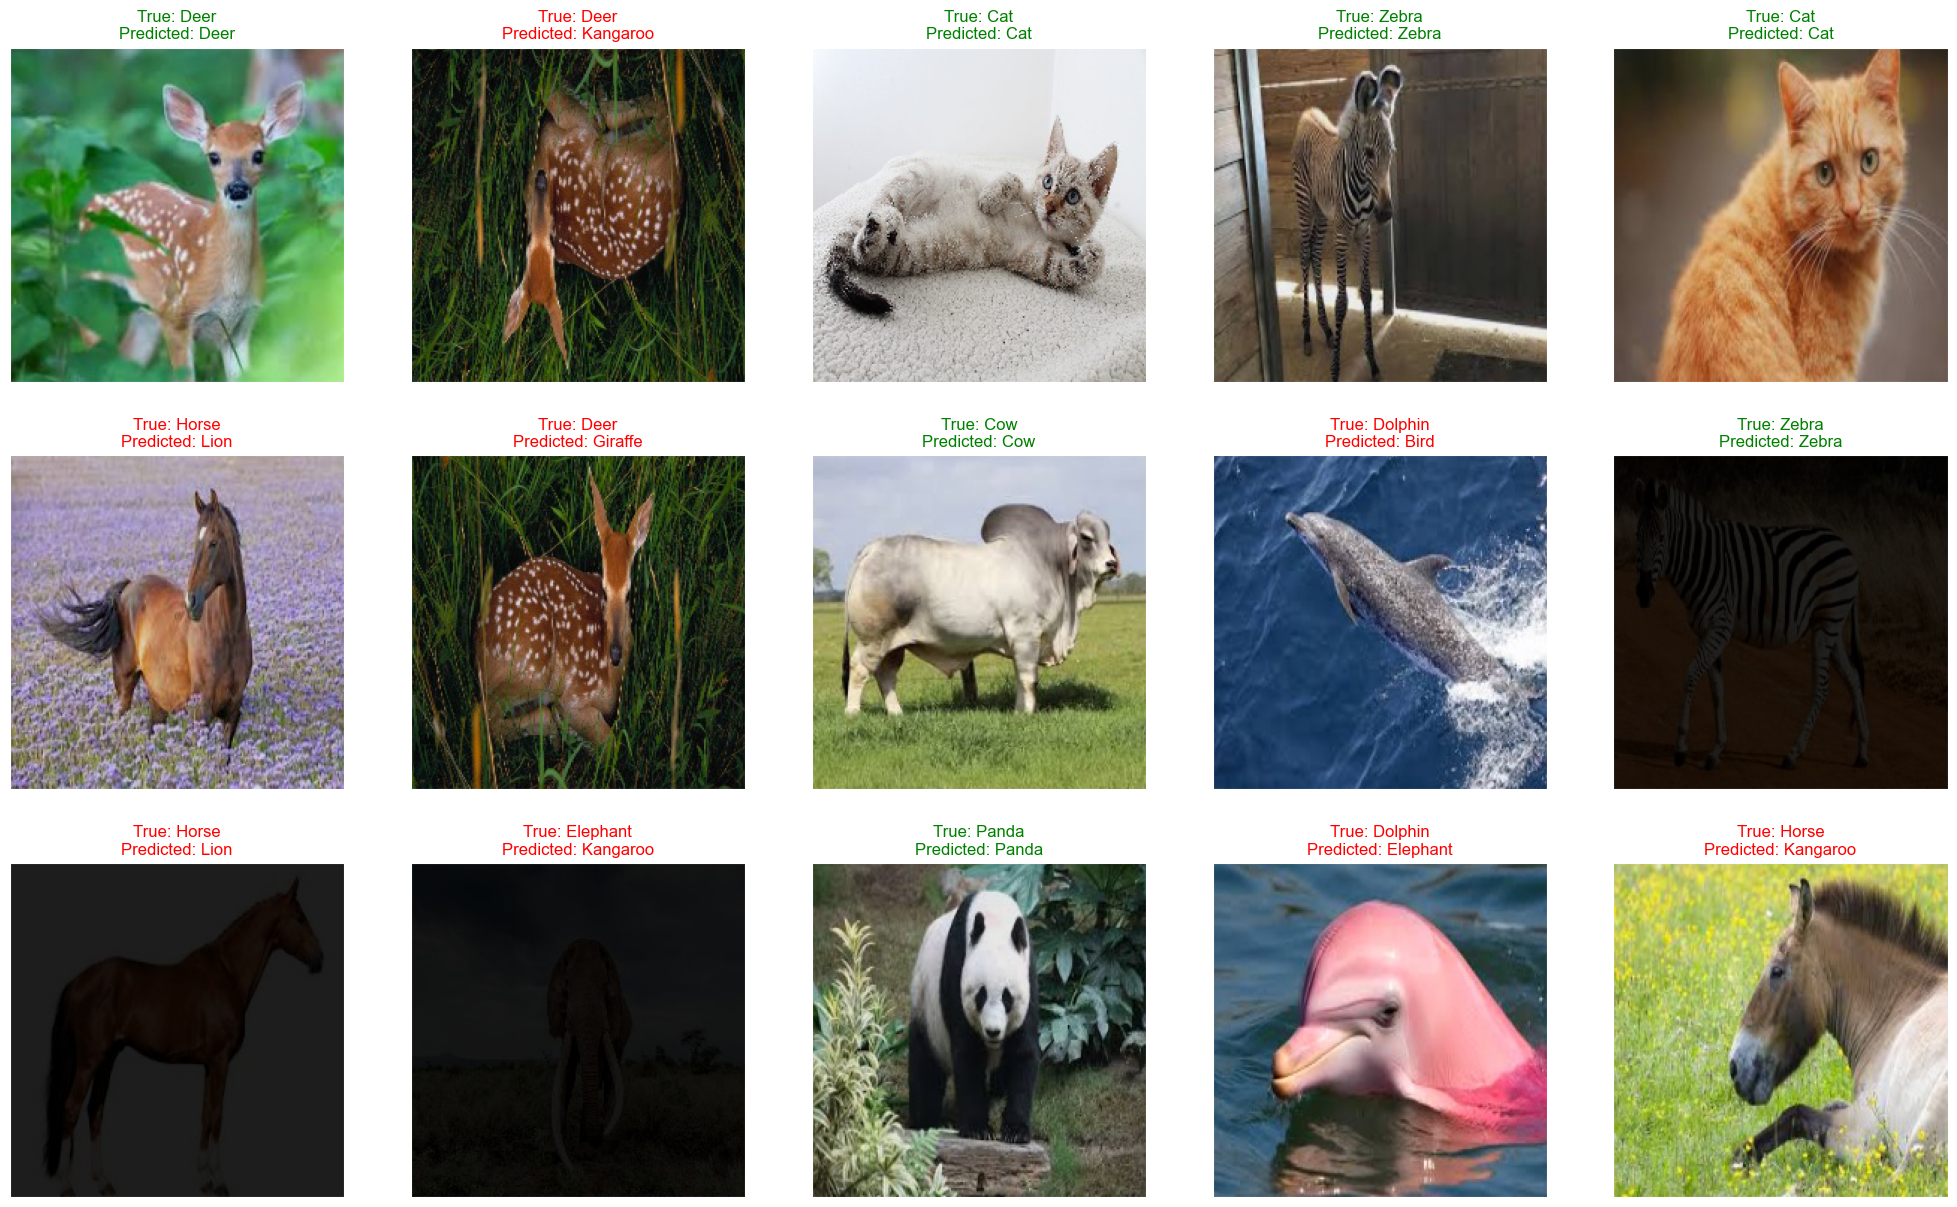

<Figure size 640x480 with 0 Axes>

In [27]:
 # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [28]:
from sklearn.model_selection import train_test_split

In [29]:


# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

In [30]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [31]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        Bear       0.57      0.62      0.59        42
        Bird       0.52      0.31      0.39        52
         Cat       0.50      0.65      0.57        49
         Cow       0.29      0.14      0.19        50
        Deer       0.54      0.58      0.56        52
         Dog       0.00      0.00      0.00        49
     Dolphin       0.10      0.02      0.04        46
    Elephant       0.46      0.85      0.60        46
     Giraffe       0.41      0.40      0.40        50
       Horse       0.67      0.16      0.26        50
    Kangaroo       0.29      0.79      0.43        38
        Lion       0.71      0.86      0.77        42
       Panda       0.54      0.67      0.60        42
       Tiger       0.82      1.00      0.90        47
       Zebra       0.81      0.98      0.89        63

    accuracy                           0.53       718
   macro avg       0.48      0.53      0.48       718
weighted avg       0.49   

In [32]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
Bear           0.565217  0.619048  0.590909   42.000000
Bird           0.516129  0.307692  0.385542   52.000000
Cat            0.500000  0.653061  0.566372   49.000000
Cow            0.291667  0.140000  0.189189   50.000000
Deer           0.535714  0.576923  0.555556   52.000000
Dog            0.000000  0.000000  0.000000   49.000000
Dolphin        0.100000  0.021739  0.035714   46.000000
Elephant       0.458824  0.847826  0.595420   46.000000
Giraffe        0.408163  0.400000  0.404040   50.000000
Horse          0.666667  0.160000  0.258065   50.000000
Kangaroo       0.291262  0.789474  0.425532   38.000000
Lion           0.705882  0.857143  0.774194   42.000000
Panda          0.538462  0.666667  0.595745   42.000000
Tiger          0.824561  1.000000  0.903846   47.000000
Zebra          0.805195  0.984127  0.885714   63.000000
accuracy       0.532033  0.532033  0.532033    0.532033
macro avg      0.480516  0.534913  0.477722  718.000000
weighted avg   0.487156  0.532033  0.480631  718.000000

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [43]:
cm = confusion_matrix(y_test, pred)


In [46]:
type(y_test)

list

In [49]:
y_test

['Panda',
 'Cat',
 'Cow',
 'Panda',
 'Deer',
 'Tiger',
 'Bear',
 'Dolphin',
 'Dolphin',
 'Giraffe',
 'Cat',
 'Zebra',
 'Lion',
 'Lion',
 'Lion',
 'Giraffe',
 'Bird',
 'Kangaroo',
 'Zebra',
 'Cow',
 'Elephant',
 'Dog',
 'Lion',
 'Cat',
 'Cat',
 'Elephant',
 'Bird',
 'Cat',
 'Kangaroo',
 'Zebra',
 'Bear',
 'Cat',
 'Lion',
 'Bird',
 'Cat',
 'Horse',
 'Zebra',
 'Bird',
 'Bear',
 'Panda',
 'Horse',
 'Dolphin',
 'Cow',
 'Horse',
 'Panda',
 'Dolphin',
 'Panda',
 'Elephant',
 'Horse',
 'Deer',
 'Dolphin',
 'Dog',
 'Lion',
 'Panda',
 'Horse',
 'Dog',
 'Tiger',
 'Horse',
 'Deer',
 'Cat',
 'Bear',
 'Dog',
 'Bear',
 'Cat',
 'Elephant',
 'Tiger',
 'Dog',
 'Dog',
 'Dog',
 'Zebra',
 'Giraffe',
 'Cow',
 'Lion',
 'Panda',
 'Cow',
 'Kangaroo',
 'Lion',
 'Dog',
 'Tiger',
 'Bird',
 'Deer',
 'Cat',
 'Zebra',
 'Dolphin',
 'Zebra',
 'Lion',
 'Dolphin',
 'Cow',
 'Lion',
 'Giraffe',
 'Bird',
 'Dog',
 'Tiger',
 'Tiger',
 'Panda',
 'Horse',
 'Lion',
 'Lion',
 'Giraffe',
 'Horse',
 'Elephant',
 'Dolphin',
 'Eleph

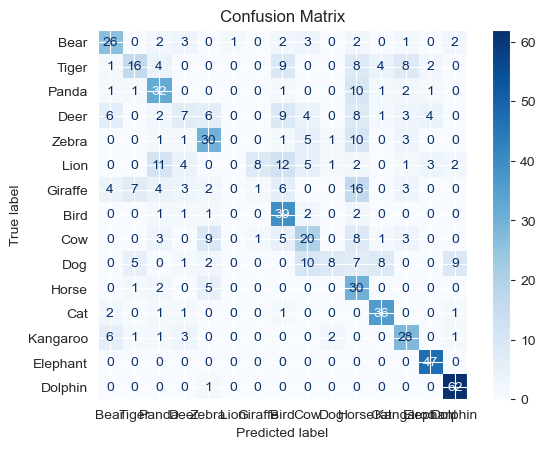

In [54]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(y_test)))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [53]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(y_test)))

In [58]:
from matplotlib import cm

jet = cm.get_cmap("jet")


C:\Users\rupsy\AppData\Local\Temp\ipykernel_19712\164760202.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


In [61]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

C:\Users\rupsy\AppData\Local\Temp\ipykernel_19712\3614164838.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


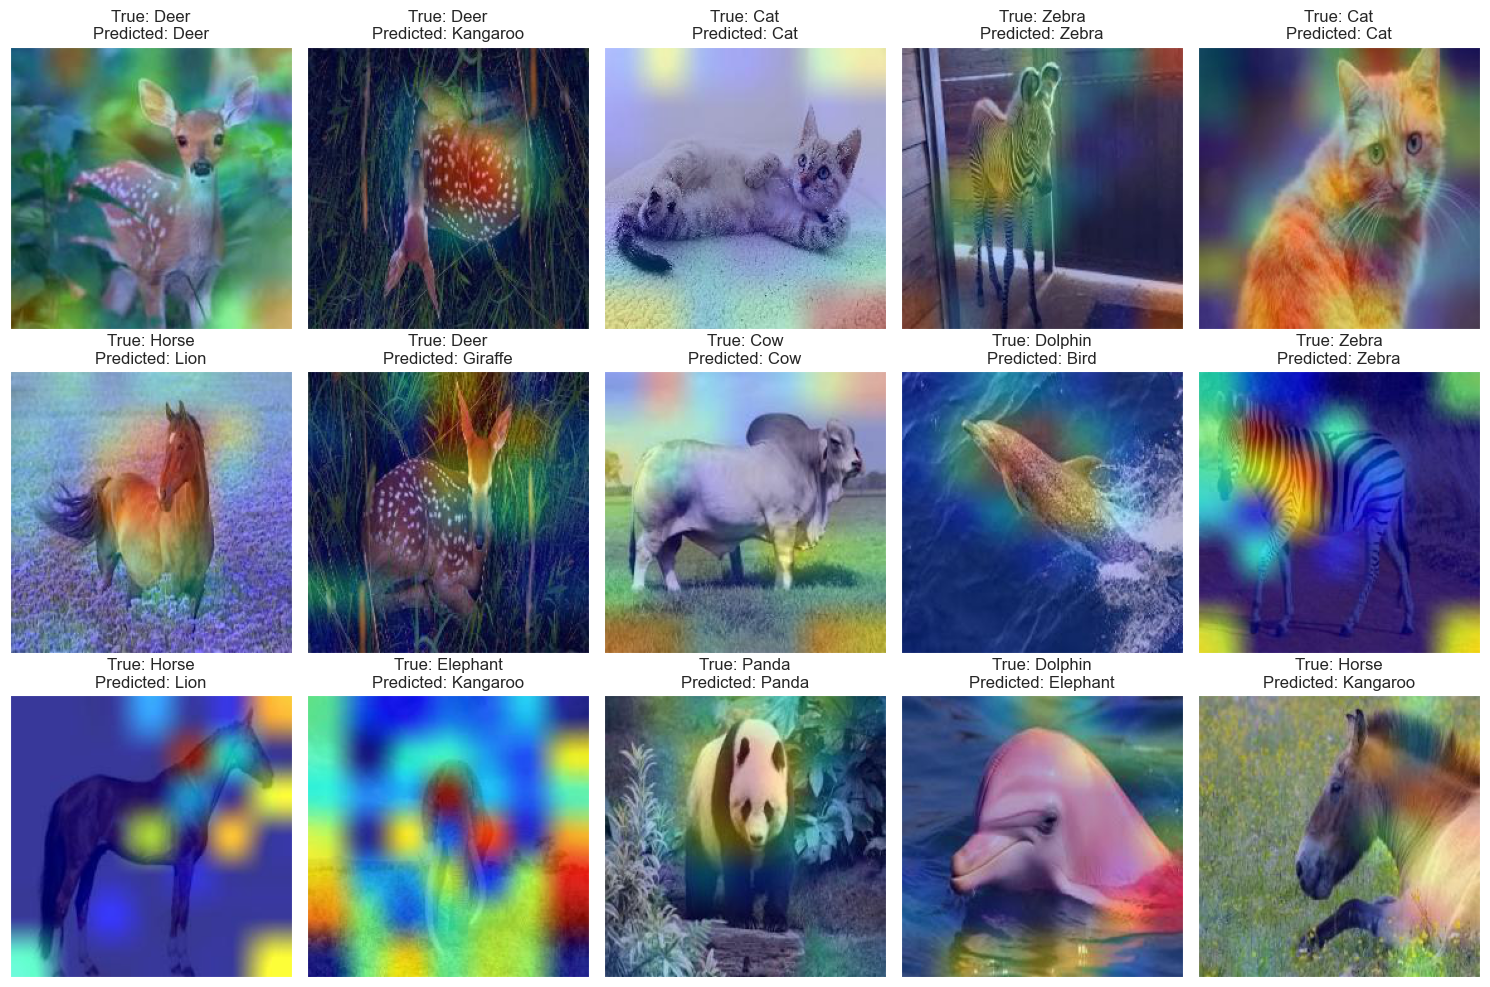

In [62]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()